In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Hide code:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# lifetimes packages:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import ModifiedBetaGeoFitter # for MBG/NBD
from lifetimes import GammaGammaFitter # for gamma gamma
from lifetimes import BetaGeoFitter # for BG/NBD

# Predicting Future Purchasing from Transaction History by Modified BG Model
by [Eden Huang](https://www.linkedin.com/in/eden-huang/)

## Table of Contents

### [Introduction](#introduction)


## Section I. Implementation of modified BG models with `Lifetimes` 

### 1.1 [Data processing](#preprocessing)

### 1.2 [Ranking of customers by count of purchases](#ranking_count)

### 1.3 [Ranking of customers by total spend](#ranking_value)


## Section II. Assumptions of modified BG models

### 2.1 [Model assumptions](#assumptions)

### 2.2 [Compare assumptions with reality](#check_assumptions)


## Section III. Simulation on random sample of customers

### 3.1 [Motivation](#motivation)

### 3.2 [Simulation results](#simulation_results)


## Section IV. Analysis & Discussion

### 4.1 [Evaluation of performance](#evaluation)

### 4.2 [Deficiencies of the model](#deficiency)

### 4.3 [Model comparisoin with mock results](#comparison)

### [Reference](#reference)


---

<a id="introduction"></a>
## Introduction

This notebook is a full tutorial of predicting future purhasing from a history of customer transactions. The models we use are: 

1. the modified beta geometric model (MBG/NBD) by [Batislam, Denizel and Filiztekin](https://www.sciencedirect.com/science/article/pii/S0167811607000171)  

2. gamma gamma model (the sub-model to estimate per-transaction dollar value under the Pareto/NBD framework that incorporates monetary value) by [Fader and Hardie](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). 

The data comes from an ecommerce store that sells widgets and represents around 50,000 transactions.

**Section I** starts with the implementation of the models (MBG/NBD and Gamma-Gamma) with [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package by [Cam-Davidson Pilon](https://github.com/CamDavidsonPilon). Then we will rank customers by highest model-predicted frequency and total spend, respectively, over the next 12 months. 

**Section II** describes the assumptions of MBG/NBD and Gamma-Gamma model. Then we compare the assumptions with the business context of ecommerce widget sales.

**Section III** goes beyond the availabile functions in `Lifetimes` Python package. The simulation shows how many customers are alive after 10 days, 1 year, 10 years and 100 years and how many purchases they have made in that time using theMBG/NBD model. For simplicity, we use a simple random sample of 100 customers and show the results for 1 run of the simulation.

**Section IV** concludes with several discussion questions around performance evaluation and model comparison. 

---

<a id="preprocessing"></a>

# Section I. Model specification

### 1.1 Data processing

We start from loading the data and converting `Timestamp` to `date`. The first date in the dataset is 2016-11-30 (Wednesday) and the last date is 2017-12-06 (Wednesday). From the data, we see some outliers with extremely high values but will keep them in modeling. Note that `Lifetimes` has an utility function to convert dataset from event log form to aggregated summary form for modeling purpose.

After weekly aggregation, our observation window covers 371 days (roughly 53 weeks), starting from Wednesday 2016-11-30 until Tuesday 2017-12-06; within the observation window, the customer base includes 23708 customers with 49945 purchase records. Ideally we would split them into cohorts based on the time of their initial purchases. However for simplicity we would model all customers regardless of cohorts. The next 365 days (12 months) will be set as holdout period. 

In [2]:
df = pd.read_csv("data-science-exercise-data.csv")
df['date'] = pd.to_datetime(df['Timestamp']).dt.normalize()
df = df.drop(columns=["Timestamp"])
df.head()

,CustomerID,PurchaseValue,date
0,5611860a94204a4078659f1667372cc4,4.72,2017-02-09
1,07b260307114f9cffc5601eb7ad4b565,5.33,2017-06-28
2,1ede55062d0d68c70fc4d355a5328d11,5.35,2017-07-28
3,42b8e86e8da5e35628bcdc146c358665,6.00,2016-12-17
4,1047f2787b7efc759d7ffcbc40ef7e19,6.28,2016-12-05


In [3]:
df.describe()

,PurchaseValue
count,49945.000000
mean,236.888196
std,245.760987
min,4.720000
25%,97.100000
50%,166.660000
75%,286.790000
max,11599.680000


In [4]:
df.date.describe()

count                   49945
unique                    371
top       2017-11-29 00:00:00
freq                     1092
first     2016-11-30 00:00:00
last      2017-12-06 00:00:00
Name: date, dtype: object

The structure of the aggregated data is as follows:
- `Recency` ($t_x$) is calculated as the most recent transaction within $T$ less time of the first transaction
- `Frequency` ($x$) is number of *repeat* transactions the customer has made
- `T` is equal to the end observation period less first purchase made by the customer (implied age)
- `Monetary_value` is the mean transaction value of the customer's purchasing history (only applied to those with *repeat* purchase)

The unit of time is in days. 

In [5]:
# convert to aggregated summary form:
summary = summary_data_from_transaction_data(
    df, customer_id_col='CustomerID', datetime_col='date', monetary_value_col='PurchaseValue',
    observation_period_end='2017-12-06', freq='D'
)
summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


In [6]:
summary.describe()

,frequency,recency,T,monetary_value
count,23708.000000,23708.000000,23708.000000,23708.000000
mean,1.025477,58.355154,204.519403,94.028495
std,2.111326,98.565275,110.976868,168.026439
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,117.000000,0.000000
50%,0.000000,0.000000,209.000000,0.000000
75%,1.000000,86.000000,307.000000,146.722500
max,95.000000,371.000000,371.000000,3420.700000


Note that for gamma-gamma model that estimates per-transaction spend, we only consider customers that have repeat purchases. Out of 23708 customers in the data, only 9647 of them had repeat purchases.

In [7]:
# convert to aggregated summary form:
summary_repeated_cust = summary[summary.frequency > 0]
summary_repeated_cust.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540
00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440
000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782


In [8]:
summary_repeated_cust.describe()

,frequency,recency,T,monetary_value
count,9647.000000,9647.000000,9647.000000,9647.000000
mean,2.520162,143.410801,241.842231,231.079875
std,2.681129,108.063394,97.187225,194.203336
min,1.000000,1.000000,1.000000,5.350000
25%,1.000000,43.000000,172.000000,109.411667
50%,2.000000,130.000000,250.000000,177.890000
75%,3.000000,228.000000,329.000000,283.495833
max,95.000000,371.000000,371.000000,3420.700000


<a id="ranking_count"></a>

### 1.2 Ranking of customers by count of purchases

We use the MBG/NBD fitter in `Lifetimes` for the prediction of count. 

In [9]:
import random
random.seed(1) # set seed for reproducibility

def fit_mbg_nbd(data):
    from lifetimes import ModifiedBetaGeoFitter # for MBG/NBD
    data = data.copy() # create a copy of data
    # fit the model using MBG/NBD fitter:
    fitter = ModifiedBetaGeoFitter(penalizer_coef=0.0)
    fitter.fit(data['frequency'], data['recency'], data['T'])
    return fitter

# fit the MBG/NBD model:
bgf = fit_mbg_nbd(data=summary)
bgf

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.54, alpha: 85.27, b: 1.45, r: 0.79>

After building the model, we list the 100 customers predicted to make the most purchases over the next 12 months. Among the top 100 customers, the highest count of predicted purchases is around 64 with fairly large variance (skewed to the right). 

In [10]:
def ranking_frequency(data, fit, t, n):
    data = data.copy()
    data['predicted_purchases_count'] = fit.conditional_expected_number_of_purchases_up_to_time(
        t, data['frequency'], data['recency'], data['T']
    )
    return data.sort_values(by='predicted_purchases_count', ascending=False).head(n).round(2)

ranking_freq = ranking_frequency(data=summary, fit=bgf, t=365, n=100)
ranking_freq

,frequency,recency,T,monetary_value,predicted_purchases_count
CustomerID,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,433.96,64.47
48a503edbaded96a3be27deee11967a1,46.0,363.0,371.0,220.48,30.92
9f447f9415a380ac2eeee7df49c6ee7e,23.0,163.0,166.0,110.20,25.95
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.12,25.06
8d2ce54737dd404d20cadf1405d46dc8,33.0,360.0,362.0,123.20,22.92
a62a17bb46864da2c6da691d838971b3,30.0,366.0,366.0,307.96,20.75
3b11478939967e896ae2619615650f97,20.0,190.0,194.0,58.87,20.73
2ad9a83ee23110d8c2f4c01600b94f20,29.0,357.0,364.0,146.42,19.94
75fda9ea22086bf3814ff8c3f53de8ca,28.0,348.0,355.0,196.03,19.60


In [11]:
ranking_freq.predicted_purchases_count.describe()

count    100.00000
mean      13.33760
std        6.44201
min        9.61000
25%       10.17500
50%       11.66500
75%       13.69750
max       64.47000
Name: predicted_purchases_count, dtype: float64

<a id="ranking_value"></a>

### 1.3 Ranking of customers by total spend

We use the Gamma-Gamma fitter in `Lifetimes` to estimate the average spend per transaction, and then multiply by the predicted count by MBG/NBD to get the estimated total spend over the next 12 months. Recal that we only consider customers with repeat transactions in the model. 

In [12]:
import random
random.seed(1) # set seed for reproducibility

def fit_gamma_gamma(data):
    from lifetimes import GammaGammaFitter # for gamma gamma

    data=data.copy()
    # fit the model using Gamma-Gamma fitter:
    fitter = GammaGammaFitter(penalizer_coef=0.0)
    fitter.fit(data['frequency'], data['monetary_value'])
    return fitter

# fit the Gamma-Gamma model:
ggf = fit_gamma_gamma(data=summary_repeated_cust)
ggf

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>

In [13]:
data = summary_repeated_cust.copy()
bgf.conditional_expected_number_of_purchases_up_to_time(
        365, data['frequency'], data['recency'], data['T']
    ).describe()

count    9647.000000
mean        2.265651
std         2.045134
min         0.001550
25%         1.033351
50%         1.707032
75%         2.895285
max        64.472862
dtype: float64

In [14]:
def ranking_monetary_value(data, transaction_prediction_model, submodel_fit, t, n):
    data = data.copy()
    data['expected_average_profit'] = submodel_fit.conditional_expected_average_profit(data['frequency'], data['monetary_value'])
    data['predicted_purchases_count'] = transaction_prediction_model.conditional_expected_number_of_purchases_up_to_time(
        t, data['frequency'], data['recency'], data['T']
    )
    data['predicted_total_spend'] = data['expected_average_profit']*data['predicted_purchases_count']
    
    return data.sort_values(by='predicted_total_spend', ascending=False).head(n).round(2)

ranking_spend = ranking_monetary_value(data=summary_repeated_cust, transaction_prediction_model=bgf, submodel_fit=ggf, t=365, n=100)
ranking_spend

,frequency,recency,T,monetary_value,expected_average_profit,predicted_purchases_count,predicted_total_spend
CustomerID,,,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,95.0,371.0,371.0,433.96,432.75,64.47,27900.70
ca2202a96c2de6ca6b8a37a4a73fa730,7.0,12.0,20.0,1399.63,1310.47,15.62,20467.89
dca76db00cc59dfbcdcc97c8bbc7f9f1,19.0,339.0,364.0,966.42,944.74,12.63,11927.52
5ac5ed64cd99ed2a8403b7a927e644ef,23.0,222.0,250.0,627.44,617.77,17.92,11069.45
60c19a709e3ced2d16d7100eb1069df5,10.0,292.0,300.0,1259.27,1203.08,8.07,9712.11
98f8e41f45721cbe49a3147f6cf62432,3.0,39.0,71.0,1757.86,1511.04,5.01,7575.76
5f01420f0edda6555df5ce1cc62b986c,39.0,350.0,370.0,299.12,298.17,25.06,7471.17
a92534133444b5028d12a129b1b128f7,6.0,66.0,75.0,772.83,725.36,10.05,7289.56
089ecc49200cfe79584d0bec2a3cf8c0,2.0,125.0,134.0,2937.12,2329.53,3.11,7251.17


Among the top 100 customers with highest expected total spend, we see a combination of "low-frequency-high-average" and "high-frequency-low-average" customers. Similar to what we obvserved about the predicted count, the model predicted total spend is also skewed to the right with large variance. 

In [15]:
ranking_spend.predicted_total_spend.describe()

count      100.000000
mean      5057.972300
std       3266.458007
min       3217.160000
25%       3499.227500
50%       3873.110000
75%       5504.175000
max      27900.700000
Name: predicted_total_spend, dtype: float64

---

<a id="assumptions"></a>

## Section II. Assumptions of modified BG models

### 2.1 Model assumptions

Given the model input as "recency-frequency matrix" format, the modified BG/NBD generates four model outputs $r$, $α$, $a$ and $b$ characterized by the five assumptions. Recall that BG/NBD and Pareto/NBD are different in the modeling of dropout process, while MBG/NBD modifies the BG/NBD model by including an additional chance of dropout immediately after the first purchase of a customer, keeping all other assumptions in BG/NBD unchanged. Compared to BG/NBD, including one more dropout condition may improve the model flexibility of MBG/NBD, especially for zero repurchasers. 

The number of purchases while a customer is active follows the NBD (Poisson-gama mixture) counting process. Accordingly, the two following assumptions are about the purchase process:

#### **Assumption 1: While active, transactions made by a consumer in time period $t$ is Poisson distributed with mean $λt$**

Poisson distribution expresses the probability of a given number of transactions occurring in a fixed interval of time $t$ when these events occur with a known constant rate $λ$ and independently of the time since the last event. Intuitively, we would expect $λt$ numer of transactions throughout the period $t$. 
 
**Figure 1.1** shows the probability distribution related to the number of transactions for one individual consumer with $λ$ = 1 (e.g. one transaction per day on average):

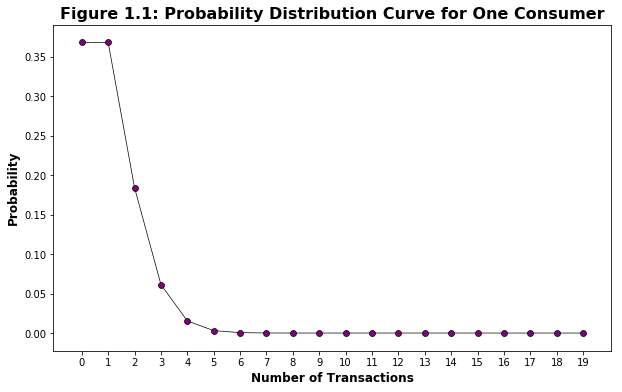

In [16]:
from scipy.stats import poisson

# plot the probability distribution curve:
probability_arr = []
distribution = poisson(1)
for transactions in range(0,20):
     probability_arr.append(distribution.pmf(transactions))

plt.figure(figsize=(10,6))
plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.1: Probability Distribution Curve for One Consumer', fontsize=16, fontweight='bold')
plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='purple', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()

#### **Assumption 2: Hetereogeneity in transaction rates $λ$ across consumers follows a Gamma distribution with shape $r$ and scale $α$**

The Gamma distribution is often used to model time to failure, and arises naturally when the time between occurences are Poisson distributed. In particular, $r$ and $α$ are the two hyperparameters of Gamma distribution: $r$ controls the *shape* and *skewness* of distribution, while larger $α$ leads to wider *spread* of the distribution.
 
Using the model estimates from MBG/NBD model as an example, **Figure 1.2** shows the probability distributions related to number of transactions for 100 consumers with $r$ = 0.76 and $α$ = 83.27 (an extremely wide scale):

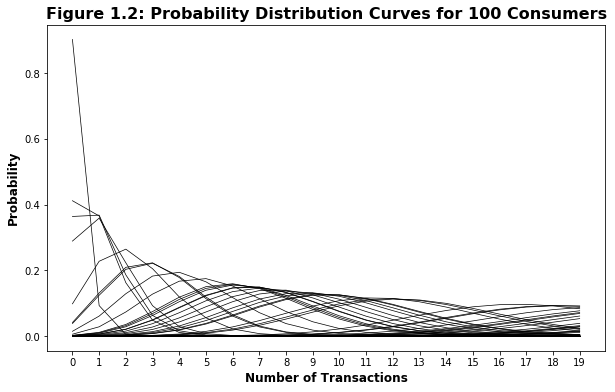

In [17]:
plt.figure(figsize=(10,6))

# estimates from MBG/NBD model:
a= 0.57; alpha= 83.27; b= 1.63; r= 0.76

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=r, scale=alpha))
    probability_arr = []
    for transactions in range(0,20):
        probability_arr.append(distribution.pmf(transactions))
    plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)

plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.2: Probability Distribution Curves for 100 Consumers', fontsize=16, fontweight='bold')
plt.show()

Modeling of the dropout process is the major difference between Pareto/NBD and BG/NBD (and MBG/NBD) models. The BG/NBD model assumes that a dropout can occur only immediately after a purchase, while MBG/NBD adds additional chance of dropout at time zero based on BG/NBD:

#### **Assumption 3: Each consumer becomes inactive after each transaction and at time zero with probability $p$**

#### **Assumption 4: Differences in $p$ follows a beta distribution with shape parameters $a$ and $b$**

Using the estimates from MBG/NBD model as an example, the model assumes a random dropoff with probability $p$ that is Beta distributed with two hyperparameters $a$ =  and $b$ = to each of our 100 consumers after each transaction. Both $a$ and $b$ are shape parameters that together control the shape of distribution.

Compared to **Figure 1.2**, we can see from **Figure 1.3** that this transformation moves the distribution to the left. The intuition is that after each transaction, the consumer can potentially drop out with certain probability. Such modified assumption leads to an increased likelihood of fewer transactions.

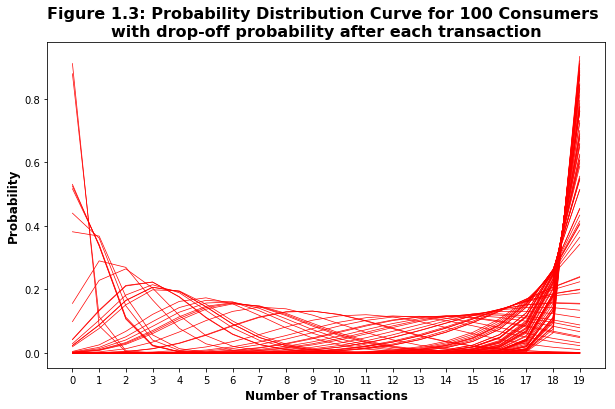

In [18]:
plt.figure(figsize=(10,6))

# estimates from MBG/NBD model:
a= 0.57; alpha= 83.27; b= 1.63; r= 0.76

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=r, scale=alpha))
    probability_arr = []
    beta = np.random.beta(a=a, b=b)
    cumulative_beta = 0
    for transactions in range(0,20):
        proba = distribution.pmf(transactions)
        cumulative_beta = beta + cumulative_beta - (beta * cumulative_beta)
        inactive_probability = 1 - cumulative_beta
        proba *= inactive_probability
        probability_arr.append(proba)
    probability_arr = np.array(probability_arr)
    probability_arr /= probability_arr.sum()
    plt.plot(probability_arr, color='red', linewidth=0.7, zorder=1)

plt.ylabel('Probability', fontsize=12, fontweight='bold')
plt.xlabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.xticks(range(0, 20))
plt.title('Figure 1.3: Probability Distribution Curve for 100 Consumers \nwith drop-off probability after each transaction', 
          fontsize=16, fontweight='bold')
plt.show()

#### **Assumption 5**: Transaction rate and dropout probability vary independently between consumers

This assumption captures the "heterogeneity" in both transaction occurences and dropout processes for consumers.

Now we move on to the model that incorporates monetary value. According to the notes of Hardie and Fader, the Gamma-Gamma model of spend per transaction is based on the following three general assumptions:

- **Assumption 1**: The monetary value of a customer’s given transaction
varies randomly around their average transaction value.

- **Assumption 2**: Average transaction values vary across customers but do not vary over
time for any given individual.

- **Assumption 3**: The distribution of average transaction values across customers is independent of the transaction process.

<a id="check_assumptions"></a>

### 2.2 Compare assumptions with reality


In the context of ecommerce sales, most assumptions are fairly realistic for most typical types of widgets. As for the modified BG model, the additional chance of dropout at time zero particularly matches the ecommerce purchase behavior that accounts for the "come-and-go" buyers. The three assumptions on Gamma-Gamma submodel are also generally satisfied in the ecommerce setting. 

However, the major limitation of these assumptions is the inability to incorporate seasonality effects and promotional/marketing events. For example, with the release of some trendy products, related equipments can witness a sudden boost. Similarly, extreme weather such as a major hurricane can significantly increase or decrease certain sales depending on the types of product the store sells. Marketing variables and promotional activities are not easily incorporated in the model as well. The model assumptions also fail to capture macroeconomic effects such as inflation or change of general market landscape. 

---

<a id="motivation"></a>

## Section III. Simulation on random sample of customers

### 3.1 Motivation

Suppose we want to simulate how many customers are alive after 10 days, 1 year, 10
years and 100 years and how many purchases they have made in that time using the
modified BG model. We use a simple random sample of 100 customers and show the
results for 1 run of the simulation. Often it is interesting to look at this range of values, but
for this exercise, we are only looking for you to show us the result of one run.

First, let us generate a uniform random sample of 100 customers (from the aggregated ID-by-RFM form) and fit the MBG/NBD model on these customers. Since the sample size is fairly small, the RFM values vary wildly between samples and so are the model estimates. Therefore, the number of active customers and total purchases also vary across different samples. Note that the threshold of "active customers" depends on the business scenario. For simplicity, we define them as those with probability of being active greater than 0.5.

In [653]:
def draw_customers(data, n):
    # sample size needs to be smaller than size of population
    if n > data.frequency.count():
        raise Exception('sample size should not exceed population of customer')
    
    random_customers = data.sample(n).index
    df = data.loc[data.index.isin(random_customers)]
    return df

df_100 = draw_customers(summary, 100)
df_100.sort_values('frequency', ascending = False).head(5)

,frequency,recency,T,monetary_value
CustomerID,,,,
0d6b2ec49235fc36e18c2b27d5b19a26,11.0,336.0,351.0,300.239091
5af7b737a0c76a6c7e1055c3923b8559,5.0,130.0,149.0,54.582000
4b1eb90aa90e5c12fa5e22c6d7b34a20,4.0,279.0,306.0,249.460000
f33a78bf3bffcb6dd687bde07f10f641,4.0,286.0,371.0,108.210000
e9d788fb71c2f0a597c92a26c53eb879,3.0,337.0,344.0,175.820000


In [695]:
fitter = ModifiedBetaGeoFitter(penalizer_coef=0.0)
fitter.fit(df_100['frequency'], df_100['recency'], df_100['T'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 100 subjects, a: 0.82, alpha: 118.65, b: 2.19, r: 0.77>

In [612]:
def simulate_mbg_nbd(data, t):
    from lifetimes import ModifiedBetaGeoFitter # for MBG/NBD

    data = data.copy()
    # fit the model using MBG/NBD fitter:
    fitter = ModifiedBetaGeoFitter(penalizer_coef=0.0)
    fitter.fit(data['frequency'], data['recency'], data['T'])
    res = pd.DataFrame()
    res['customerID'] = data.index.tolist()
    res['predicted_purchases_count'] = fitter.conditional_expected_number_of_purchases_up_to_time(
        t, data['frequency'], data['recency'], data['T']
    ).values
    res['probability_alive'] = fitter.conditional_probability_alive(
        data['frequency'], data['recency'], data['T']
    ).values
    return res

res_100 = simulate_mbg_nbd(df_100, t=10)
res_100.head()

,customerID,predicted_purchases_count,probability_alive
0,01c981b485a024d7ef57f5abb767c192,0.075024,0.776946
1,0722bfa7be177b5b624e62071ea138bb,0.054783,0.564238
2,07cd2412de040fece322b908e497ca9e,0.011342,0.380599
3,108cc95d58326398e3728fb81c11a71e,0.022396,0.490821
4,13e71c97c2f38ad530361777a905fb76,0.022252,0.535600


<a id="simulation_results"></a>

### 3.2 Simulation results

Now we organize the previous steps in a simulation funciton. The simulation shows a different number of customers alive each time the code is evaluated.

In [672]:
def res_count(data, n, t, cutoff_prob):
    """
    Return count of total purchases and number of customers alive over time on a uniform sample. Model for simulation is MBG/NBD.
    
    Parameters
    ----------
    data: data in RFM form
    n: sample size of simulation
    t: total time of simulation (in days)
    cutoff_prob: cutoff probability to define the status of active
    
    Returns
    -------
    Dataframe with count values and sample size
    """  
    # Draw 100 customers:
    customer_sample = draw_customers(data, n)
    # Fit MBG/NBD model:
    res = simulate_mbg_nbd(customer_sample, t)
    # Count number of purchases and active customers:
    df = pd.DataFrame({'Simulation_Sample_Size':n,
                       'Simulation_Time':t,
                       'Count_Total_Purchases':res.predicted_purchases_count.sum().round(2),
                       'Count_Active_Customers':res[res['probability_alive']>cutoff_prob].probability_alive.count()},
                      index=['Values'])
    return df

res_count(data=summary, n = 100, t=10, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,100,10,3.64,74


Then we repeat the simulation for 1 year (365 days), 10 years (3652) and 100 years (36524) including leap years within the time frames:

In [674]:
res_count(data=summary, n = 100, t=365, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,100,365,115.17,88


In [680]:
res_count(data=summary, n = 100, t=3652, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,100,3652,951.41,60


In [681]:
res_count(data=summary, n = 100, t=36524, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,100,36524,1539.04,14


---

<a id="evaluation"></a>

## Section IV. Analysis & Discussion

### 4.1 Evaluation of performance


The model works well when the parameters estimates are reasonable. However, with small sample size, the model estimates are fairly unstable. The greatest challenge for these types of models is the difficulty to differentiate between low frequency purchases (recently purchased with long inter-purchase time) and the actual drop-out. For example, when a customer only purchased twice in the entire year of observation, once at the beginning and once near the end, then the model is likely to identify this customer as "active" and produces an extremely steady dropout process, even lasting to near infinity. His is particularly an issue when most customers in the sample have low-frequency transactions. That's one of the reasons why we see that in some runs of simulation, most customers are always active regardless of the length of forecasting window. 

In [687]:
N = summary.frequency.count().copy()
res_count(data=summary, n = N, t=10, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,10,1040.68,16121


In [688]:
res_count(data=summary, n = N, t=365, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,365,30873.02,16121


In [689]:
res_count(data=summary, n = N, t=3652, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,3652,168771.55,16121


In [690]:
res_count(data=summary, n = N, t=36524, cutoff_prob=0.5)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,36524,634139.58,16121


In [702]:
N = summary.frequency.count().copy()
res_count(data=summary, n = N, t=10, cutoff_prob=0.3)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,10,1040.68,22998


In [698]:
res_count(data=summary, n = N, t=365, cutoff_prob=0.3)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,365,30873.12,22998


In [699]:
res_count(data=summary, n = N, t=3652, cutoff_prob=0.3)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,3652,160394.77,23028


In [701]:
res_count(data=summary, n = N, t=36524, cutoff_prob=0.3)

,Simulation_Sample_Size,Simulation_Time,Count_Total_Purchases,Count_Active_Customers
Values,23708,36524,634149.07,22998


<a id="deficiency"></a>

### 4.2 Deficiencies of the model


To address the deficiencies of the model, I would suggest the following ideas:

- 1) Divide customers into cohort

    Instead of drawing customers from the entire observation period, divide them into different cohorts by time of first transaction. Customers in the same cohort are more likely to share common characteristics and the model results can be more stable. Analysis comparing can also produce more potential business insights.


- 2) Aggregate daily data into weeks

    Most of the customers in the dataset have low frequency purchases. The current model does not benefit from the granular data. Grouping transactions into weeks are likely to produce more stable estimates. 
    
    
- 3) Modify the generating process

    In practice, there're natural constraints imposed on the customers. Consider modify the data generating assumptions that match the business scenario. 

<a id="comparison"></a>

### 4.3 Model comparisoin with mock results

Suppose the intended use of the modified BG model is binning customers into one of the following categories: highly likely to purchase in the next year, somewhat likely to purchase in the next year, unlikely to purchase in the next year, highly unlikely to purchase in the next year. Suppose also that we want to compare the modified BG model with the original BG/NBD model using the same ecommerce widgets sales data. These two models can be evaluated following the agenda below. Note that **Step 1 -- 3** are for comparison prior to classification, while **Step 4** is for binning customers: 

- **Step 1** Compare parameter estimates (and calculate log-likelihood):

   Both MBG/NBD and BG/NBD are estimated by MLE method. We can comare the model estimates and the log-likelihood functions (the higher the better). The log-likelihood functions have closed-form solution given data and model parameters. 
   
   For example, the model estimates of MBG/NBD and BG/NBD on this data are not drastically different. Ideally, we want to split the training data into several *cohorts* and compare model coefficients across cohorts. 


- **Step 2** Compare model fit -- evaluate the differences between estimated and actual frequencies of repeat purchases with bar plot and *chi-square goodness-of-fit tests*:

   For example, **Figure 1.3** shows that MBG/NBD provides slightly more accurate prediction for customers with no repeat purchase and zero purchase -- this could be explained by the additional assumption of immediate dropout for MBG/NBD. 
   
   To further test the deviations of both models from the actual frequency, we can conduct the chi-square goodness of fit tests between model estimates (MBG/NBD and BG/NBD respectively) and actual. Recall that the chi-square tests are essentially the analog of the one-way t-test for categorical variables. We can also use another chi-square test to compare MBG/NBD and BG/NBD to see if the two models are "close" enough. 
   
   
- **Step 3** Compare forecasting performance in the holdout period:

    - 1) Compare model predicting **aggregated-level** repeat purchases (by week or month) with actual in the holdout period. We will see how the candidate models track actual purchases throughout the time and whether they converge to the actual. We can also calculate the weekly or monthly *MAPE* (mean percentage absolute error; the lower the better) on the holdout period to compare the model performance.

    - 2) Compare **individual-level** relative forecasting performance in terms of "conditional expectations for the holdout period, broken down by the number of repeat purchases during the observation period". Then we could confirm the comparison results by an *one-way ANOVA* (if test not significant then the differences between models are not large enough). Although it is difficult to model individual purchase behavior for the highly heterogeneous group in ecommerce sales, the prediction validity at the individual level is still crucial in supporting the strength of these models, i.e. the ability in individual level analysis. 
    
    
- **Step 4** Compare segmentation/classification:
    
    After evaluating model results in the "raw form", we can check the prediction validity of customer segmentation, i.e. binning customers into categories. We compare a set of cutoff probabilities for each group and come up with the bins that are realatively *balanced*. We will handle imbalancedness separately if necessary (SMOTE or ADASYN etc.). Then we move on to compare candidate models on the evaluation metrics of this mult-class classification problem.
    
    Instead of relying on one single statistics such as accuracy, we will a combination of evaluation metrics (classification accuracy, confusion matrix, Cohen's Kappa, ROC/AUC and sensitivity/recall, F1 Score). It is rare that a model outperforms the other on every category. In practice, we need to pick the model that have high accuracy and are generally better on the categories that matter to the business context most. 

In [406]:
np.random.seed(1)

def fit_mbg_nbd(data):
    from lifetimes import ModifiedBetaGeoFitter
    
    data = data.copy()
    # fit the model using MBG/NBD fitter:
    fitter = ModifiedBetaGeoFitter(penalizer_coef=0.0)
    fitter.fit(data['frequency'], data['recency'], data['T'])
    return fitter

# fit the MBG/NBD model:
mbgf = fit_mbg_nbd(data=summary)
mbgf

<lifetimes.ModifiedBetaGeoFitter: fitted with 23708 subjects, a: 0.54, alpha: 85.27, b: 1.45, r: 0.79>

In [405]:
np.random.seed(1)http://localhost:8899/notebooks/Desktop/careers/Data_Challenges/Klaviyo_BMGGG/BG_Eden_Huang.ipynb#

def fit_bg_nbd(data):
    from lifetimes import BetaGeoFitter
    
    data = data.copy()
    # fit the model using BG/NBD fitter:
    fitter = BetaGeoFitter(penalizer_coef=0.0)
    fitter.fit(data['frequency'], data['recency'], data['T'])
    return fitter

# fit the BG/NBD model:
bgf = fit_bg_nbd(data=summary)
bgf

<lifetimes.BetaGeoFitter: fitted with 23708 subjects, a: 0.57, alpha: 60.57, b: 2.95, r: 0.41>

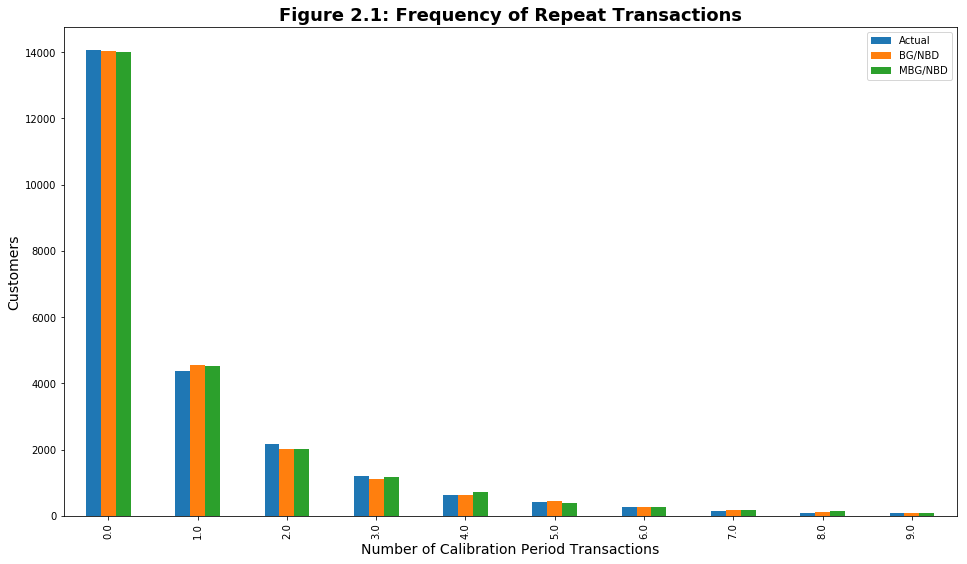

In [413]:
def compare_period_transactions(
    model_1,model_2,max_frequency,lab_model1,lab_model2,fig_label,
    title="Frequency of Repeat Transactions",xlabel="Number of Calibration Period Transactions",ylabel="Customers",
    **kwargs
):
    """
    Plot a figure with period actual and two predicted transactions.
    """
    from matplotlib import pyplot as plt
    
    n = model_1.data.shape[0]
    simulated_data_1 = model_1.generate_new_data(size=n)
    simulated_data_2 = model_2.generate_new_data(size=n)

    n = model.data.shape[0]
    simulated_data = model.generate_new_data(size=n)

    model_counts = pd.DataFrame(model_1.data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts_1 = pd.DataFrame(simulated_data_1["frequency"].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts_2 = pd.DataFrame(simulated_data_2["frequency"].value_counts().sort_index().iloc[:max_frequency])
    combined_counts = pd.concat([model_counts, simulated_counts_1, simulated_counts_2], axis=1)
    combined_counts.columns = ["Actual", lab_model1, lab_model2]

    ax = combined_counts.plot(kind="bar", figsize=(16,9), **kwargs);
    
    plt.legend()
    plt.title(fig_label+title, fontsize=18, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    
    return ax, simulated_counts_1, simulated_counts_2

comparison = compare_period_transactions(model_1=bgf, model_2=mbgf, fig_label="Figure 2.1: ", max_frequency=10, lab_model1="BG/NBD",lab_model2="MBG/NBD")
comparison[0]

---

<a id="reference"></a>
## Reference

* [Counting Your Customers The Easy Way, Peter S. Fader and Bruce Hardie](http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf)

* [Counting Your Customers One By One, A Hierarchical Bayes Extension to the Pareto/NBD Model, Peter S. Fader and Jen Shang](http://www.brucehardie.com/papers/020/)

* [RFM and CLV: Using iso-value curves for customer base analysis, Peter S. Fader and Bruce Hardie](http://brucehardie.com/papers/rfm_clv_2005-02-16.pdf)

* [The Gamma-Gamma Model of Monetary Value, Peter S. Fader and Bruce Hardie](http://www.brucehardie.com/notes/025/gamma_gamma.pdf)

* [Empirical validation and comparison of models for customer base analysis, Batislam, E.P., M. Denizel, A. Filiztekin](https://www.sciencedirect.com/science/article/pii/S0167811607000171)
